## Exercise 1

Sketch a contextsensitive Application

Categorize it according to Schilit (explain why)

Categorize all relevant context regarding category of context, passive/active and primary/secondary

Modify a. to be in another class according to Schilit (Tip: You may modify the previous answer if this does not work)



# Exercise 3 Calculating features

b. Use your code from the last excercise to collect data for 3 activities with 10 subjects each for 30 seconds (Note: note down each subject as an extra tag in influxdb. You can join forces to collect bigger datasets or change eg. the position of your phone and repeat yourself)



e. Join all timeseries into a single dataframe. Add your label and experiment/subject to each observation.

f. Use caret to visualize your feature space.

g. Extend your code to easily try out and visualize different features


## Load Data from API

c. Use InfluxDBr2 to load the data that you collected in excercise 2 into an xts object (use one xts per label and experiment) 

-> Use Node.js Backend and API to get Data via influent

In [152]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import rcParams
import numpy as np

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from pandas.plotting import radviz

import warnings
warnings.simplefilter('ignore')


rcParams['figure.figsize'] = 10, 10

In [144]:
response = requests.get("http://localhost:3000/influent")
dict = response.json()['results'][0]['series'][0]
df = pd.DataFrame(data=dict['values'], columns=dict['columns'])
df = df.drop(['time', 'subject'], axis=1)
df['activity'] = df['activity'].str.strip()

In [145]:
df.describe()

,alpha,beta,gamma,stamp,x,y,z
count,6912.000000,6912.000000,6912.000000,6.912000e+03,6912.000000,6912.000000,6912.000000
mean,1.371952,-1.213033,-0.383226,1.570376e+12,0.119187,-1.493433,1.026851
std,114.813671,36.139308,40.662070,8.081357e+05,2.407892,6.991603,8.553057
min,-801.887390,-454.508118,-220.332947,1.570375e+12,-22.911385,-43.214783,-41.941494
25%,-11.593399,-7.428623,-7.768493,1.570376e+12,-0.382254,-2.195655,-0.562176
50%,-0.251788,-0.124146,0.116277,1.570377e+12,-0.005265,-0.022186,0.007377
75%,12.911134,8.331957,9.754166,1.570377e+12,0.420981,0.075503,1.120725
max,607.206238,364.143280,274.052979,1.570377e+12,26.011105,35.629875,36.468456


In [146]:
df.groupby(['activity']).count()

,alpha,beta,gamma,stamp,x,y,z
activity,,,,,,,
Jumping,2300,2300,2300,2300,2300,2300,2300
Resting,2307,2307,2307,2307,2307,2307,2307
Walking,2305,2305,2305,2305,2305,2305,2305


In [147]:
df.groupby(['activity']).mean()

,alpha,beta,gamma,stamp,x,y,z
activity,,,,,,,
Jumping,0.846996,-3.312687,-2.141838,1.570376e+12,0.399051,-4.360662,2.809627
Resting,-0.309516,-0.176518,0.091773,1.570376e+12,-0.006088,0.017402,0.005368
Walking,3.578696,-0.155346,0.896159,1.570376e+12,-0.034688,-0.144570,0.270313


## Store Data as CSV

In [148]:
df.to_csv(r'../data.csv', index=False)

## Visualizing Feature Space 

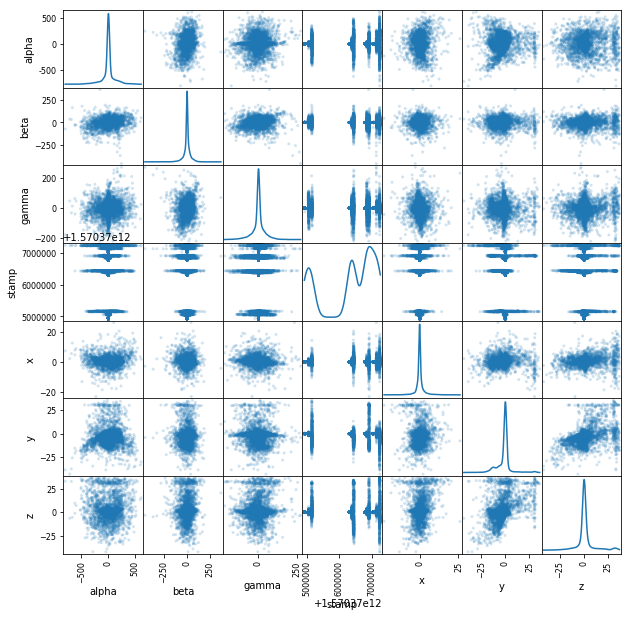

In [149]:
scatter_matrix(df, alpha=0.2, figsize=(10, 10), diagonal='kde');

In [150]:
df.corr()

,alpha,beta,gamma,stamp,x,y,z
alpha,1.000000,0.205362,0.076343,0.009595,0.038266,0.020021,0.024264
beta,0.205362,1.000000,0.127825,-0.041451,-0.067081,-0.009779,0.020964
gamma,0.076343,0.127825,1.000000,-0.027785,-0.074914,-0.052173,0.057799
stamp,0.009595,-0.041451,-0.027785,1.000000,0.027047,-0.076769,0.001600
x,0.038266,-0.067081,-0.074914,0.027047,1.000000,0.003897,0.196094
y,0.020021,-0.009779,-0.052173,-0.076769,0.003897,1.000000,0.380771
z,0.024264,0.020964,0.057799,0.001600,0.196094,0.380771,1.000000


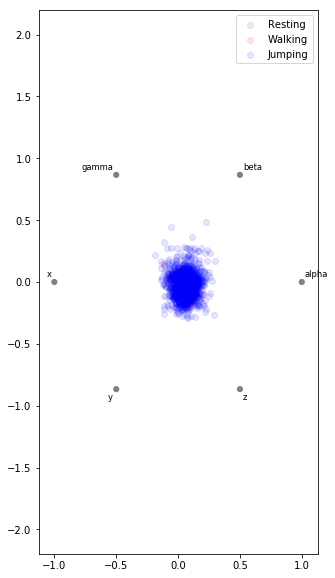

In [151]:
df_tmp = df.drop(['stamp'], axis=1, inplace=False)
radviz(df_tmp, class_column='activity', alpha=0.1, color=['green', 'red', 'blue'])

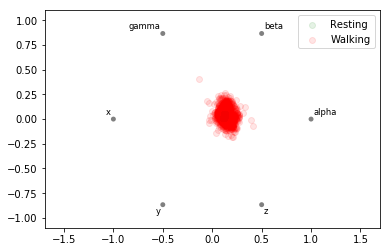

In [10]:
radviz(df_tmp[df_tmp['activity'] != 'Jumping'], class_column='activity', alpha=0.1, color=['green', 'red', 'blue'])

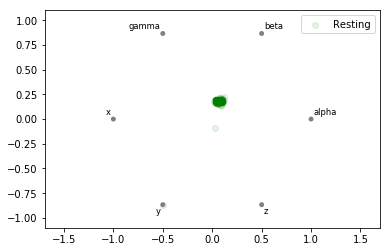

In [11]:
radviz(df_tmp[df_tmp['activity'] == 'Resting'], class_column='activity', alpha=0.1, color=['green', 'red', 'blue'])

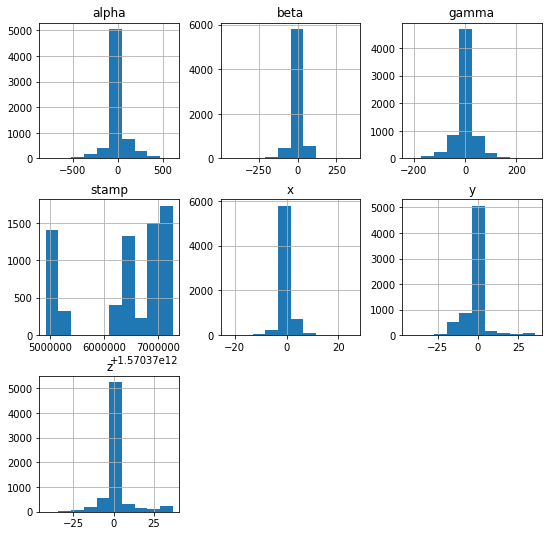

In [12]:
df.hist(figsize=(9,9))
plt.show()

## Windowing
Apply a non-overlapping window of 1s to the data.

In [160]:
X = []
y = []

skip_count = 0
class_names = []
colors = ['red', 'green', 'blue']

def visualize_column(column):
    for i, activity in enumerate(df['activity'].unique()[::-1]):
        for index in np.arange(0, (df['activity'] == activity).shape[0], 20):
            window = df[(df['activity'] == activity)][index:index+20]
            plt.plot(range(window.shape[0]), window[column], c=colors[i], alpha=0.2)
            
    plt.title(column)
    plt.legend(handles=[mpatches.Patch(color=color, label=name) for name, color in zip(class_names, colors)]);
    plt.show()

for i, activity in enumerate(df['activity'].unique()[::-1]):
    print(activity)
    class_names.append(activity)
    for index in np.arange(0, (df['activity'] == activity).shape[0], 20):
        window = df[(df['activity'] == activity)][index:index+20]
            
        if window.shape[0] < 1:
            skip_count += 1
            continue;
        row = [
            window['alpha'].mean(),
            window['beta'].mean(),
            window['gamma'].mean(),
            window['x'].mean(),
            window['y'].mean(),
            window['z'].mean(),

            window['alpha'].var(),
            window['beta'].var(),
            window['gamma'].var(),
            window['x'].var(),
            window['y'].var(),
            window['z'].var()
        ]
        X.append(row)
        y.append(i)

Jumping
Walking
Resting


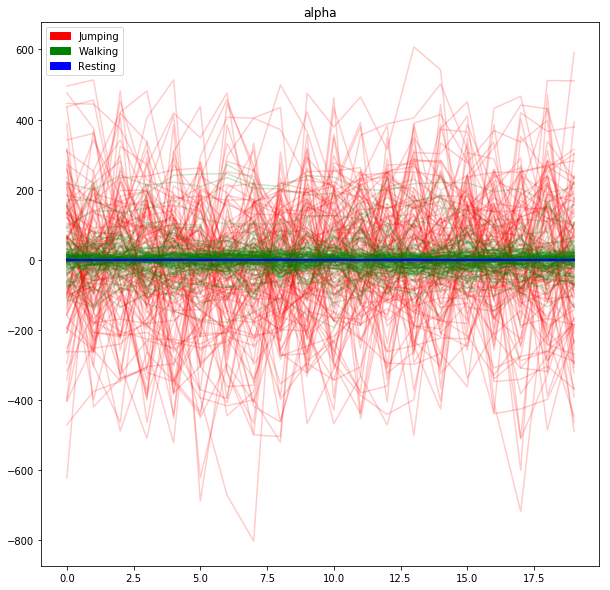

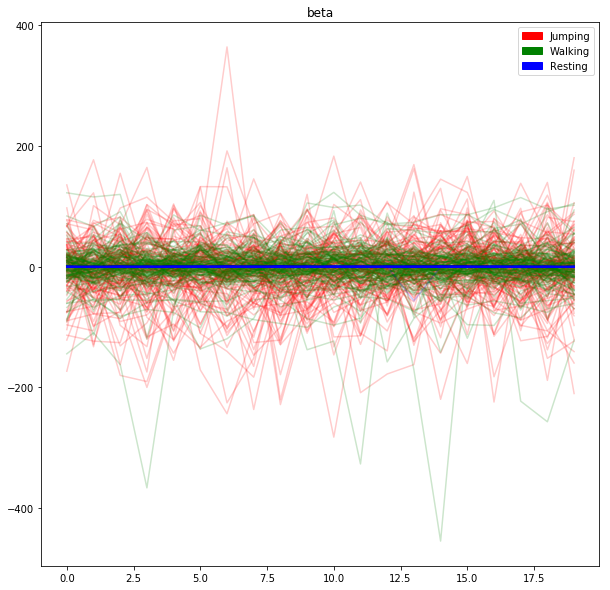

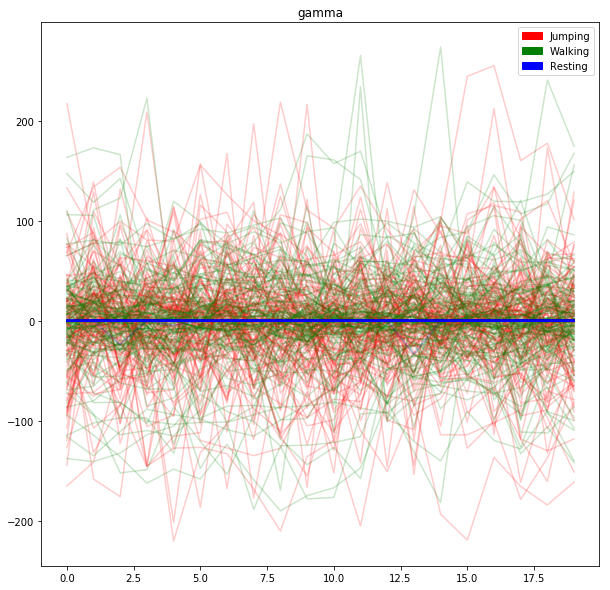

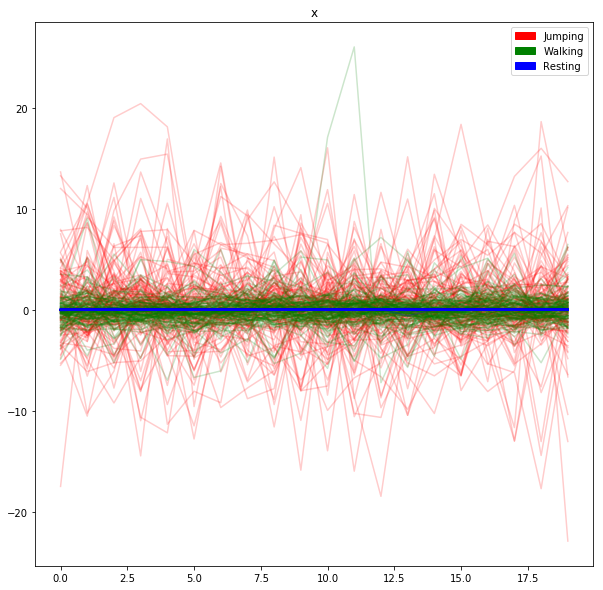

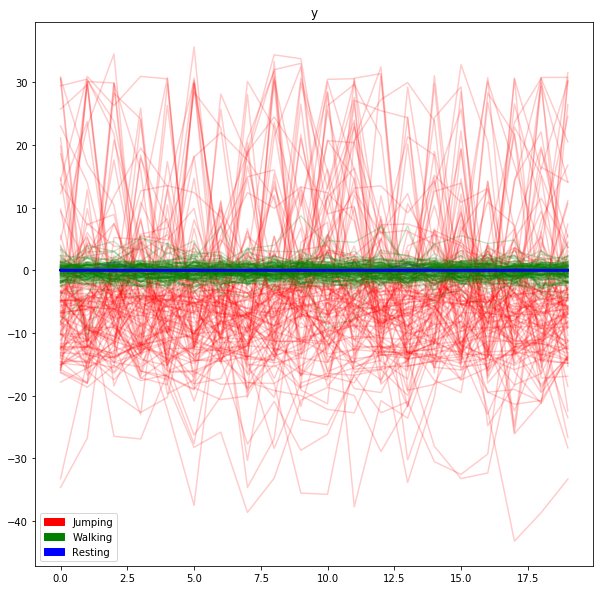

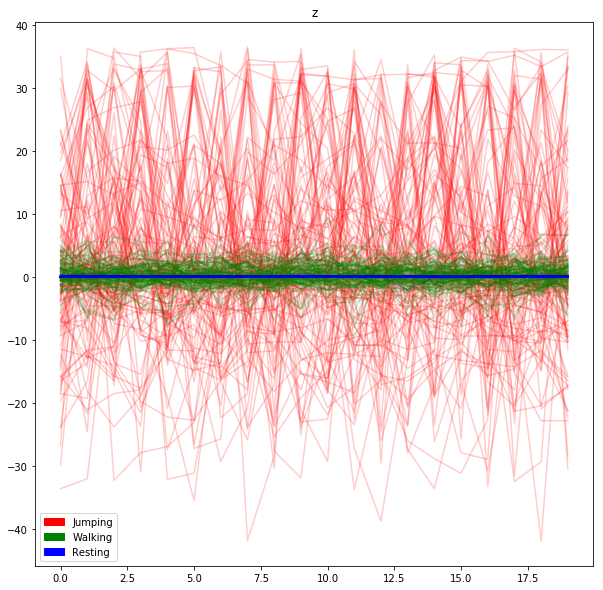

In [162]:
# visualize frames

for column_name in df:
    if column_name not in ('stamp', 'activity'):
        visualize_column(column_name)

In [90]:
X_data = pd.DataFrame(X, columns=['alpha_mean', 'beta_mean', 'gamma_mean',
                                  'x_mean', 'y_mean', 'z_mean',
                                  'alpha_var', 'beta_var', 'gamma_var',
                                  'x_var', 'y_var', 'z_var'])

X_data.describe()

,alpha_mean,beta_mean,gamma_mean,x_mean,y_mean,z_mean,alpha_var,beta_var,gamma_var,x_var,y_var,z_var
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,1.622392,-1.158173,-0.341813,0.119870,-1.486194,1.025101,13104.132987,1157.138864,1111.975986,5.552839,39.740829,71.366950
std,26.661853,14.348893,24.357936,0.720182,3.312139,2.252867,27481.648531,2066.921840,1876.289916,10.690054,84.964783,143.736233
min,-121.031782,-112.257886,-125.282805,-1.756754,-18.962383,-6.444785,0.075211,0.041235,0.002822,0.000057,0.000068,0.000114
25%,-0.855402,-2.774456,-4.324460,-0.122092,-1.628454,-0.000147,0.216351,0.132073,0.029847,0.000320,0.000341,0.000358
50%,-0.176776,-0.190896,0.127555,-0.000472,-0.042426,0.051089,678.808295,333.207386,374.906078,0.596907,1.077819,2.660969
75%,5.872651,2.089514,4.151946,0.278852,0.044194,1.254843,14064.024778,1241.930794,1487.785478,6.447453,23.503646,70.883755
max,193.238049,66.760520,98.858737,4.658726,5.431473,13.485479,195875.961585,17213.234983,19325.565742,69.980857,411.639333,735.362984


In [132]:
?plt.legend

In [91]:
y_data = np.array(y)

In [92]:
# count unique labels
np.unique(y_data, return_counts=True)

(array([0, 1, 2]), array([116, 116, 115]))

## Visualize again after Windowing

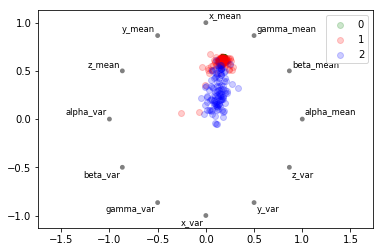

In [17]:
windowed = X_data.copy()
windowed['label'] = y_data
radviz(windowed, class_column='label', color=['green', 'red', 'blue'],alpha=0.2,)

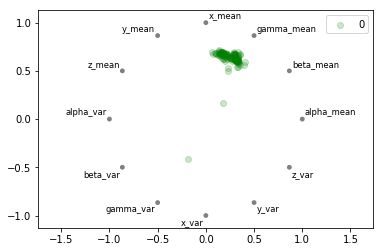

In [18]:
radviz(windowed[windowed['label'] == 0], class_column='label', alpha=0.2, color=['green', 'red', 'blue'])

## Creating a predictor

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [21]:
clf = SVC()
param_dist = {
    'kernel': ['linear']
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=20, cv=10)

In [22]:
random_search.fit(X_train, y_train);
print(random_search.best_estimator_)
print(random_search.best_score_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.9783393501805054


In [23]:
y_pred = random_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9857142857142858

## Recursive Feature Elimination

In [24]:
from sklearn.feature_selection import RFE

In [43]:
selector = RFE(random_search.best_estimator_, 3, step=1)
selector = selector.fit(X_train, y_train)
print("Selector Support: {}".format(selector.support_))
print("Selector Ranking: {}".format(selector.ranking_))

Selector Support: [ True False False False False False  True False False False  True False]
Selector Ranking: [ 1  7  3  9  5 10  1  6  4  8  1  2]


In [44]:
print("Chosen features: {}".format(np.array(list(X_train))[selector.support_]))

Chosen features: ['alpha_mean' 'alpha_var' 'y_var']


## Retrain after RFE

In [76]:
# subset of dimensions

X_train_sub = X_train.iloc[:, selector.support_].copy()
X_test_sub = X_test.iloc[:, selector.support_].copy()

In [82]:
clf = SVC()
random_search = RandomizedSearchCV(clf, param_distributions={'kernel': ['linear']}, n_iter=20, cv=10)

random_search.fit(X_train_sub, y_train);
print(random_search.best_estimator_)
print(random_search.best_score_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.9891696750902527


In [84]:
y_pred = random_search.best_estimator_.predict(X_test_sub)
accuracy_score(y_test, y_pred)

1.0

## Write model to javascript

In [46]:
from sklearn_porter import Porter

In [110]:
porter = Porter(random_search.best_estimator_, language='JS')
output = porter.export(embed_data=True)
output

'var SVC = function(nClasses, nRows, vectors, coefficients, intercepts, weights, kernel, gamma, coef0, degree) {\n\n    this.nClasses = nClasses;\n    this.classes = new Array(nClasses);\n    for (var i = 0; i < nClasses; i++) {\n        this.classes[i] = i;\n    }\n    this.nRows = nRows;\n    this.vectors = vectors;\n    this.coefficients = coefficients;\n    this.intercepts = intercepts;\n    this.weights = weights;\n    this.kernel = kernel.toUpperCase();\n    this.gamma = gamma;\n    this.coef0 = coef0;\n    this.degree = degree;\n\n    this.predict = function(features) {\n    \n        var kernels = new Array(vectors.length);\n        var kernel;\n        switch (this.kernel) {\n            case \'LINEAR\':\n                // <x,x\'>\n                for (var i = 0; i < this.vectors.length; i++) {\n                    kernel = 0.;\n                    for (var j = 0; j < this.vectors[i].length; j++) {\n                        kernel += this.vectors[i][j] * features[j];\n        

In [111]:
# make minor changes to JS

output = output.replace('auto_deprecated', '"auto_deprecated"')
output = output.replace("this.classes = new Array(nClasses);\n    for (var i = 0; i < nClasses; i++) {\n        this.classes[i] = i;\n    }",
             "this.classes = " + str(class_names) + ";")
output = output.replace("typeof process !== \'undefined\' && typeof process.argv !== \'undefined\'", 'true')
output = output.replace("process.argv.length - 2 === 3", "true")
output = output.replace("process.argv.slice(2);", "[0,0,0];")
print(output)

var SVC = function(nClasses, nRows, vectors, coefficients, intercepts, weights, kernel, gamma, coef0, degree) {

    this.nClasses = nClasses;
    this.classes = ['Resting', 'Walking', 'Jumping'];
    this.nRows = nRows;
    this.vectors = vectors;
    this.coefficients = coefficients;
    this.intercepts = intercepts;
    this.weights = weights;
    this.kernel = kernel.toUpperCase();
    this.gamma = gamma;
    this.coef0 = coef0;
    this.degree = degree;

    this.predict = function(features) {
    
        var kernels = new Array(vectors.length);
        var kernel;
        switch (this.kernel) {
            case 'LINEAR':
                // <x,x'>
                for (var i = 0; i < this.vectors.length; i++) {
                    kernel = 0.;
                    for (var j = 0; j < this.vectors[i].length; j++) {
                        kernel += this.vectors[i][j] * features[j];
                    }
                    kernels[i] = kernel;
                }
                break

In [112]:
# write to file

with open("../public/classifier.js", "w") as inp:
    inp.write(output)

## Exercise 7


Think about further applications and write them down
What other inputs from the browser can be used as "sensor"
What are interesting contexts